In [1]:
import random

import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.model_selection import StratifiedKFold

import sys
sys.path.append("../src/")
from lifelong_dnn import LifeLongDNN

import pandas as pd

Using TensorFlow backend.


In [2]:
random_seed = 12345
n_tasks = 10
n_shifts = 6

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])
y = y[:, 0]

num_classes = len(np.unique(y))

kfold = StratifiedKFold(n_splits = n_shifts)

In [3]:
def get_taskwise_datasets(train_shift_idxs, test_shift_idxs):
    X_train, y_train = X[train_shift_idxs], y[train_shift_idxs]
    X_test, y_test = X[test_shift_idxs], y[test_shift_idxs]
    
    X_train_across_tasks, y_train_across_tasks = [], []
    X_test_across_tasks, y_test_across_tasks = [], []
    for task_idx in range(n_tasks):
        train_idxs_of_task = np.where((y_train >= int(num_classes / n_tasks) * task_idx) & (y_train < int(num_classes / n_tasks) * (task_idx + 1)))[0]
        X_train_across_tasks.append(X_train[train_idxs_of_task])
        y_train_across_tasks.append(y_train[train_idxs_of_task] - int(num_classes / n_tasks) * task_idx)

        test_idxs_of_task = np.where((y_test >= int(num_classes / n_tasks) * task_idx) & (y_test < int(num_classes / n_tasks) * (task_idx + 1)))[0]
        X_test_across_tasks.append(X_test[test_idxs_of_task])
        y_test_across_tasks.append(y_test[test_idxs_of_task] - int(num_classes / n_tasks) * task_idx)
        
    return X_train_across_tasks, X_test_across_tasks, y_train_across_tasks, y_test_across_tasks

# Backward Transfer Efficiency

In [4]:
seeds = []
shifts = []
org_accuracies = []
tasks = []
tasks_seen = []
reverse_accuracies = []

backward_transfer_efficiencies_across_tasks_across_shifts = [[] for _ in range(n_tasks)]
def fill_in_backward_transfer_efficiencies_across_tasks(train_shift_idxs, test_shift_idxs, shift):
    X_train_across_tasks, X_test_across_tasks, y_train_across_tasks, y_test_across_tasks = get_taskwise_datasets(train_shift_idxs, test_shift_idxs)
        
    def fill_in_backward_transfer_efficiencies_per_task(task):
        lifelong_dnn = LifeLongDNN()
        backward_accuracies_across_tasks = []
        def fill_in_backward_accuracies_per_task(task_seen):
            X_train_of_task = X_train_across_tasks[task_seen]
            y_train_of_task = y_train_across_tasks[task_seen]

            lifelong_dnn.add_task(X_train_of_task , y_train_of_task, epochs = 10)

            accuracy = np.mean(y_test_across_tasks[task] == lifelong_dnn.predict(X_test_across_tasks[task], 0))
            backward_accuracies_across_tasks.append(accuracy)
            
        for task_seen in range(task, n_tasks):
            random.seed(random_seed)
            fill_in_backward_accuracies_per_task(task_seen)
            print("Backward Accuracies of Task {} Across Tasks: {}".format(task + 1, backward_accuracies_across_tasks))
            
            seeds.append(random_seed)
            shifts.append(shift)
            org_accuracies.append(backward_accuracies_across_tasks[0])
            tasks.append(task)
            tasks_seen.append(task_seen)
            reverse_accuracies.append(backward_accuracies_across_tasks[-1])

        backward_transfer_efficiencies_across_tasks = (1 - backward_accuracies_across_tasks[0]) / (1 - np.array(backward_accuracies_across_tasks))
        backward_transfer_efficiencies_across_tasks_across_shifts[task].append(backward_transfer_efficiencies_across_tasks)
        
        
    for task in range(n_tasks):
        fill_in_backward_transfer_efficiencies_per_task(task)
        
        #Plot Intermediate Results 
        for task_idx in range(task + 1):
            y_plot = np.mean(backward_transfer_efficiencies_across_tasks_across_shifts[task_idx], axis = 0)
            x_plot = range(task_idx + 1, n_tasks + 1)
            plt.plot(x_plot, y_plot, color = 'r')
        plt.ylabel("Backward Transfer Efficiency")
        plt.xlabel("Number of Tasks Seen")
        plt.title("Intermediate Result For Shift {} & Task {}".format(shift, task + 1))
        plt.xticks(range(1, n_tasks + 1))
        plt.show()

Starting Fold: 1 / 6
Backward Accuracies of Task 1 Across Tasks: [0.416]
Backward Accuracies of Task 1 Across Tasks: [0.416, 0.437]


Backward Accuracies of Task 1 Across Tasks: [0.416, 0.437, 0.451]
Backward Accuracies of Task 1 Across Tasks: [0.416, 0.437, 0.451, 0.478]
Backward Accuracies of Task 1 Across Tasks: [0.416, 0.437, 0.451, 0.478, 0.497]


Backward Accuracies of Task 1 Across Tasks: [0.416, 0.437, 0.451, 0.478, 0.497, 0.499]
Backward Accuracies of Task 1 Across Tasks: [0.416, 0.437, 0.451, 0.478, 0.497, 0.499, 0.495]


Backward Accuracies of Task 1 Across Tasks: [0.416, 0.437, 0.451, 0.478, 0.497, 0.499, 0.495, 0.51]
Backward Accuracies of Task 1 Across Tasks: [0.416, 0.437, 0.451, 0.478, 0.497, 0.499, 0.495, 0.51, 0.521]
Backward Accuracies of Task 1 Across Tasks: [0.416, 0.437, 0.451, 0.478, 0.497, 0.499, 0.495, 0.51, 0.521, 0.51]


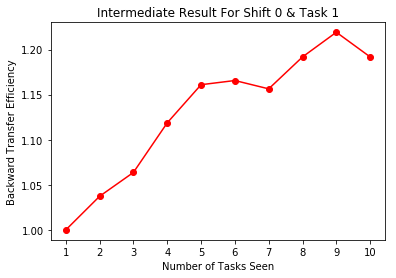

Backward Accuracies of Task 2 Across Tasks: [0.387]
Backward Accuracies of Task 2 Across Tasks: [0.387, 0.392]


Backward Accuracies of Task 2 Across Tasks: [0.387, 0.392, 0.417]
Backward Accuracies of Task 2 Across Tasks: [0.387, 0.392, 0.417, 0.446]
Backward Accuracies of Task 2 Across Tasks: [0.387, 0.392, 0.417, 0.446, 0.446]


Backward Accuracies of Task 2 Across Tasks: [0.387, 0.392, 0.417, 0.446, 0.446, 0.448]
Backward Accuracies of Task 2 Across Tasks: [0.387, 0.392, 0.417, 0.446, 0.446, 0.448, 0.453]
Backward Accuracies of Task 2 Across Tasks: [0.387, 0.392, 0.417, 0.446, 0.446, 0.448, 0.453, 0.458]


Backward Accuracies of Task 2 Across Tasks: [0.387, 0.392, 0.417, 0.446, 0.446, 0.448, 0.453, 0.458, 0.473]


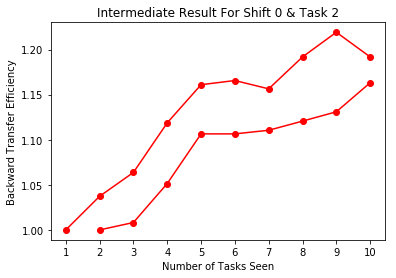

Backward Accuracies of Task 3 Across Tasks: [0.547]
Backward Accuracies of Task 3 Across Tasks: [0.547, 0.536]


Backward Accuracies of Task 3 Across Tasks: [0.547, 0.536, 0.543]
Backward Accuracies of Task 3 Across Tasks: [0.547, 0.536, 0.543, 0.549]
Backward Accuracies of Task 3 Across Tasks: [0.547, 0.536, 0.543, 0.549, 0.536]


Backward Accuracies of Task 3 Across Tasks: [0.547, 0.536, 0.543, 0.549, 0.536, 0.547]
Backward Accuracies of Task 3 Across Tasks: [0.547, 0.536, 0.543, 0.549, 0.536, 0.547, 0.558]
Backward Accuracies of Task 3 Across Tasks: [0.547, 0.536, 0.543, 0.549, 0.536, 0.547, 0.558, 0.563]


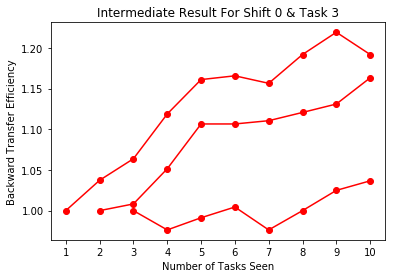

Backward Accuracies of Task 4 Across Tasks: [0.438]
Backward Accuracies of Task 4 Across Tasks: [0.438, 0.465]


Backward Accuracies of Task 4 Across Tasks: [0.438, 0.465, 0.469]
Backward Accuracies of Task 4 Across Tasks: [0.438, 0.465, 0.469, 0.475]
Backward Accuracies of Task 4 Across Tasks: [0.438, 0.465, 0.469, 0.475, 0.477]


Backward Accuracies of Task 4 Across Tasks: [0.438, 0.465, 0.469, 0.475, 0.477, 0.481]
Backward Accuracies of Task 4 Across Tasks: [0.438, 0.465, 0.469, 0.475, 0.477, 0.481, 0.491]


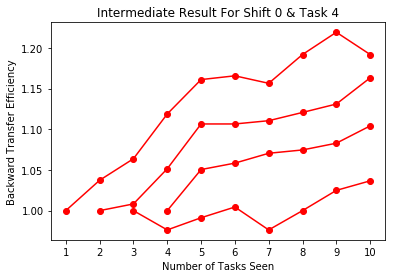

Backward Accuracies of Task 5 Across Tasks: [0.481]
Backward Accuracies of Task 5 Across Tasks: [0.481, 0.507]


Backward Accuracies of Task 5 Across Tasks: [0.481, 0.507, 0.501]
Backward Accuracies of Task 5 Across Tasks: [0.481, 0.507, 0.501, 0.509]
Backward Accuracies of Task 5 Across Tasks: [0.481, 0.507, 0.501, 0.509, 0.528]


Backward Accuracies of Task 5 Across Tasks: [0.481, 0.507, 0.501, 0.509, 0.528, 0.523]


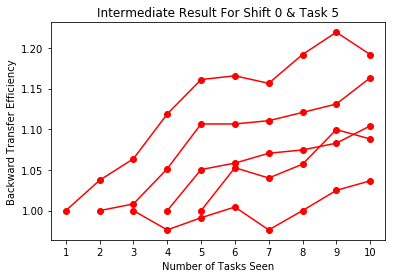

Backward Accuracies of Task 6 Across Tasks: [0.494]
Backward Accuracies of Task 6 Across Tasks: [0.494, 0.51]


Backward Accuracies of Task 6 Across Tasks: [0.494, 0.51, 0.537]
Backward Accuracies of Task 6 Across Tasks: [0.494, 0.51, 0.537, 0.542]
Backward Accuracies of Task 6 Across Tasks: [0.494, 0.51, 0.537, 0.542, 0.564]


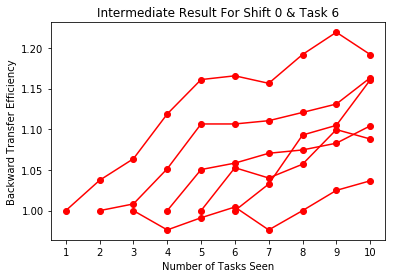

Backward Accuracies of Task 7 Across Tasks: [0.56]
Backward Accuracies of Task 7 Across Tasks: [0.56, 0.574]


Backward Accuracies of Task 7 Across Tasks: [0.56, 0.574, 0.569]
Backward Accuracies of Task 7 Across Tasks: [0.56, 0.574, 0.569, 0.581]


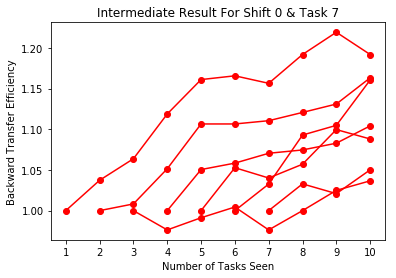

Backward Accuracies of Task 8 Across Tasks: [0.497]
Backward Accuracies of Task 8 Across Tasks: [0.497, 0.492]


Backward Accuracies of Task 8 Across Tasks: [0.497, 0.492, 0.514]


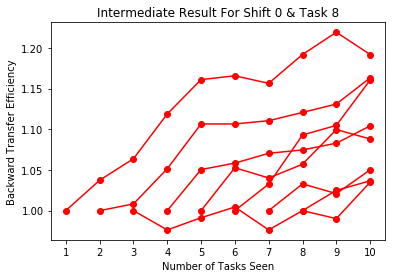

Backward Accuracies of Task 9 Across Tasks: [0.446]
Backward Accuracies of Task 9 Across Tasks: [0.446, 0.442]


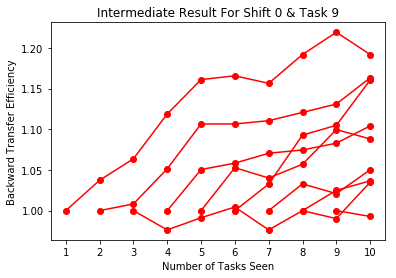

Backward Accuracies of Task 10 Across Tasks: [0.557]


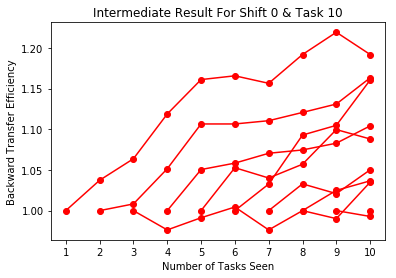

Starting Fold: 2 / 6
Backward Accuracies of Task 1 Across Tasks: [0.423]
Backward Accuracies of Task 1 Across Tasks: [0.423, 0.43]


Backward Accuracies of Task 1 Across Tasks: [0.423, 0.43, 0.452]
Backward Accuracies of Task 1 Across Tasks: [0.423, 0.43, 0.452, 0.465]
Backward Accuracies of Task 1 Across Tasks: [0.423, 0.43, 0.452, 0.465, 0.479]


Backward Accuracies of Task 1 Across Tasks: [0.423, 0.43, 0.452, 0.465, 0.479, 0.493]
Backward Accuracies of Task 1 Across Tasks: [0.423, 0.43, 0.452, 0.465, 0.479, 0.493, 0.498]


Backward Accuracies of Task 1 Across Tasks: [0.423, 0.43, 0.452, 0.465, 0.479, 0.493, 0.498, 0.511]
Backward Accuracies of Task 1 Across Tasks: [0.423, 0.43, 0.452, 0.465, 0.479, 0.493, 0.498, 0.511, 0.514]
Backward Accuracies of Task 1 Across Tasks: [0.423, 0.43, 0.452, 0.465, 0.479, 0.493, 0.498, 0.511, 0.514, 0.509]


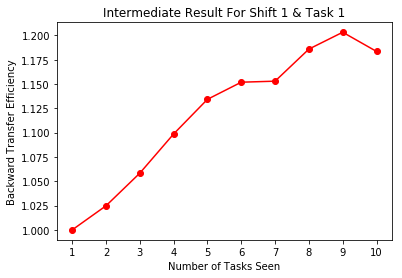

Backward Accuracies of Task 2 Across Tasks: [0.405]
Backward Accuracies of Task 2 Across Tasks: [0.405, 0.393]


Backward Accuracies of Task 2 Across Tasks: [0.405, 0.393, 0.426]
Backward Accuracies of Task 2 Across Tasks: [0.405, 0.393, 0.426, 0.444]
Backward Accuracies of Task 2 Across Tasks: [0.405, 0.393, 0.426, 0.444, 0.436]


Backward Accuracies of Task 2 Across Tasks: [0.405, 0.393, 0.426, 0.444, 0.436, 0.438]
Backward Accuracies of Task 2 Across Tasks: [0.405, 0.393, 0.426, 0.444, 0.436, 0.438, 0.454]
Backward Accuracies of Task 2 Across Tasks: [0.405, 0.393, 0.426, 0.444, 0.436, 0.438, 0.454, 0.457]


Backward Accuracies of Task 2 Across Tasks: [0.405, 0.393, 0.426, 0.444, 0.436, 0.438, 0.454, 0.457, 0.458]


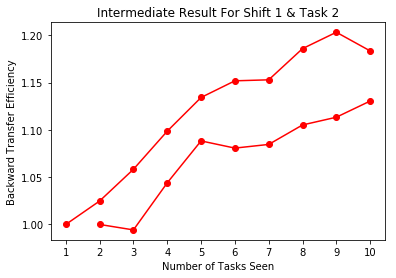

Backward Accuracies of Task 3 Across Tasks: [0.512]
Backward Accuracies of Task 3 Across Tasks: [0.512, 0.514]


Backward Accuracies of Task 3 Across Tasks: [0.512, 0.514, 0.507]
Backward Accuracies of Task 3 Across Tasks: [0.512, 0.514, 0.507, 0.521]
Backward Accuracies of Task 3 Across Tasks: [0.512, 0.514, 0.507, 0.521, 0.519]


Backward Accuracies of Task 3 Across Tasks: [0.512, 0.514, 0.507, 0.521, 0.519, 0.531]
Backward Accuracies of Task 3 Across Tasks: [0.512, 0.514, 0.507, 0.521, 0.519, 0.531, 0.528]


Backward Accuracies of Task 3 Across Tasks: [0.512, 0.514, 0.507, 0.521, 0.519, 0.531, 0.528, 0.53]


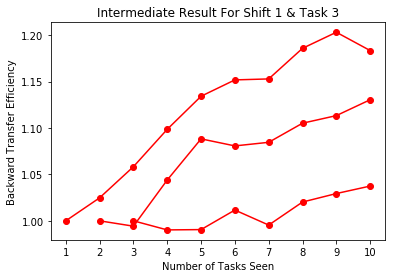

Backward Accuracies of Task 4 Across Tasks: [0.448]
Backward Accuracies of Task 4 Across Tasks: [0.448, 0.45]


Backward Accuracies of Task 4 Across Tasks: [0.448, 0.45, 0.452]
Backward Accuracies of Task 4 Across Tasks: [0.448, 0.45, 0.452, 0.479]
Backward Accuracies of Task 4 Across Tasks: [0.448, 0.45, 0.452, 0.479, 0.491]


In [ ]:
shift = 0
for train_shift_idxs, test_shift_idxs in kfold.split(X, y):
    print("Starting shift: {} / {}".format(shift + 1, n_shifts))
    fill_in_backward_transfer_efficiencies_across_tasks(train_shift_idxs, test_shift_idxs, shift)
    shift += 1

In [ ]:
backward_df = pd.DataFrame()
backward_df['seed'] = seeds
backward_df['shift'] = shifts
backward_df['org_accuracy'] = org_accuracies
backward_df['task'] = tasks
backward_df['task_seen'] = tasks_seen
backward_df['reverse_accuracy'] = reverse_accuracies

pickle.dump(open('../pkls/cifar_backward_df.p', backward_df)

# Forward Transfer Efficiency

In [5]:
seeds = []
shifts = []  
tasks = []  
org_accuracies = []  
forward_accuracies = []

In [6]:
forward_transfer_efficiencies_across_tasks_across_shifts = []
def fill_in_forward_transfer_efficiencies_across_tasks(train_shift_idxs, test_shift_idxs, shift):
    X_train_across_tasks, X_test_across_tasks, y_train_across_tasks, y_test_across_tasks = get_taskwise_datasets(train_shift_idxs, test_shift_idxs)
        
    lifelong_dnn = LifeLongDNN()
    forward_transfer_efficiencies_across_tasks = []
    def fill_in_forward_transfer_efficiencies_per_task(task):
        random.seed(random_seed)
        X_train_of_task, y_train_of_task = X_train_across_tasks[task], y_train_across_tasks[task]
        X_test_of_task, y_test_of_task = X_test_across_tasks[task], y_test_across_tasks[task]

        lifelong_dnn.add_task(X_train_of_task, y_train_of_task, epochs = 10)

        forward_accuracy = np.mean(y_test_of_task == lifelong_dnn.predict(X_test_of_task, task))
        org_accuracy = np.mean(y_test_of_task == lifelong_dnn.predict(X_test_of_task, task, transformer_task_idxs = [task]))
        
        seeds.append(random_seed)
        shifts.append(shift)
        org_accuracies.append(org_accuracy)
        tasks.append(task)
        forward_accuracies.append(forward_accuracy)
        
        forward_transfer_efficiency_of_task = (1 - org_accuracy) / (1 - forward_accuracy)
        forward_transfer_efficiencies_across_tasks.append(forward_transfer_efficiency_of_task)
        
    for task in range(n_tasks):
        fill_in_forward_transfer_efficiencies_per_task(task)

        print("Forward Transfer Efficiencies: {}".format(forward_transfer_efficiencies_across_tasks))
    forward_transfer_efficiencies_across_tasks_across_shifts.append(forward_transfer_efficiencies_across_tasks)

In [ ]:
shift = 0
for train_shift_idxs, test_shift_idxs in kfold.split(X, y):
    print("Starting Shift: {} / {}".format(shift + 1, n_shifts))
    fill_in_forward_transfer_efficiencies_across_tasks(train_shift_idxs, test_shift_idxs, shift)
    shift += 1

Starting Shift: 1 / 6
Forward Transfer Efficiencies: [1.0]
Forward Transfer Efficiencies: [1.0, 1.0136752136752136]


Forward Transfer Efficiencies: [1.0, 1.0136752136752136, 1.0021008403361344]
Forward Transfer Efficiencies: [1.0, 1.0136752136752136, 1.0021008403361344, 1.090038314176245]


In [ ]:
x_plot = range(1, n_tasks + 1)
y_plot = np.mean(forward_transfer_efficiencies_across_tasks_across_shifts, axis = 0)
plt.plot(x_plot, y_plot, 'o-', color = 'r')
plt.ylabel("Forward Transfer Efficiency")
plt.xlabel("Number of Tasks Seen")
plt.title("Forward Transfer Efficiencies Across Tasks")
plt.xticks(range(1, n_tasks + 1))
plt.show()

In [21]:
forward_df = pd.DataFrame()
forward_df['seed'] = seeds
forward_df['shift'] = shifts
forward_df['org_accuracy'] = org_accuracies
forward_df['task'] = tasks
forward_df['forward_accuracy'] = forward_accuracies

pickle.dump(forward_df, open('../pkls/cifar_forward_df.p', 'wb'))